# Hypothesis Analysis

## Setup environment

### Import Packages

In [812]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import pathlib
import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy import signal
import pandas as pd
import ruptures as rpt
from time_window import TimeWindow
import random

from smart_simulation.cfg_templates.config import package_dir

### Connect to data

In [847]:
# Get path to raw weights data
raw_data_path = (
    pathlib.Path(package_dir) / "smart_simulation/outputs/simulations"
)

weights_path = raw_data_path / 'weights'

servings_path = raw_data_path / 'servings'

# List all weights files
weights_file_list = [p for p in weights_path.iterdir() if p.is_file()]
servings_file_list = [p for p in servings_path.iterdir() if p.is_file()]

## Sample EDA

### Raw Data Visualization

In [4]:
# Get sample
sample = pd.read_csv(flist[0], parse_dates=True, index_col=0)
sample.head()

,weight
2020-01-01 00:00:00,14.000000
2020-01-01 06:00:00,13.601856
2020-01-01 12:00:00,13.601856
2020-01-01 18:00:00,13.601856
2020-01-02 00:00:00,13.144815


In [5]:
def plot_weights(dates, weights, title, sample_label, bar=False):
    
    dates_array_shape = dates.shape
    weights_array_shape = weights.shape
    
    if len(dates_array_shape) != 1:
        dates = dates.reshape(-1)
    if len(weights_array_shape) != 1:
        weights = weights.reshape(-1)
    
    days = mdates.WeekdayLocator()
    months = mdates.MonthLocator()
    years = mdates.YearLocator()  
    months_fmt = mdates.DateFormatter('%m')
    
    fig, ax = plt.subplots(figsize=(18, 6))
    
    if bar:
        ax.bar(dates, weights, label=sample_label)
    else:
        ax.plot(dates, weights, label = sample_label)

    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set(xlabel='Date', ylabel='Weight (oz)', title=title)
    ax.legend()


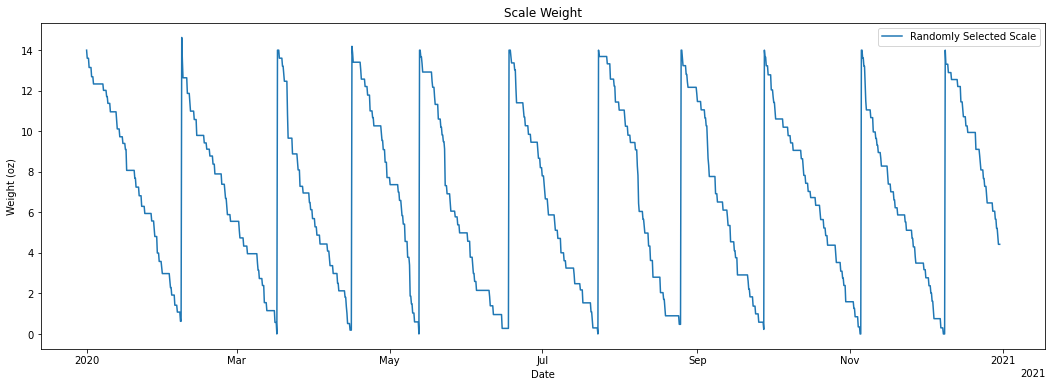

In [6]:
plot_weights(sample.index, sample.values, 'Scale Weight', 'Randomly Selected Scale', bar = False)

### Consumption


In [7]:
raw_consumption = -1 * sample.weight.diff()

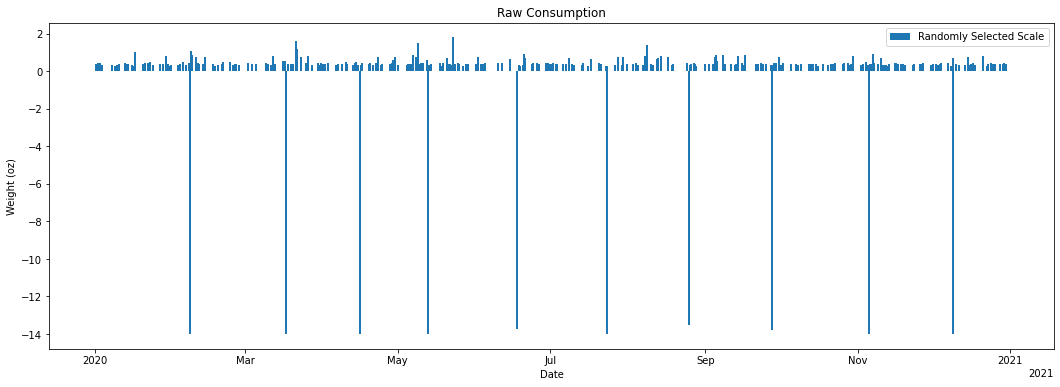

In [8]:
plot_weights(raw_consumption.index, raw_consumption.values, 'Raw Consumption', 'Randomly Selected Scale', bar = True)

#### Raw Frequency Analysis

In [9]:
def calculate_consumption(weight_data):
    raw_consumption = -1 * weight_data.diff()
    raw_consumption.loc[raw_consumption == -0] = 0 # prior transform converts 0 to -0
    with_new_product = raw_consumption.copy()
    with_new_product.loc[raw_consumption < 0] += 14
    return with_new_product

In [785]:
clean_consumption = calculate_consumption(sample.weight)

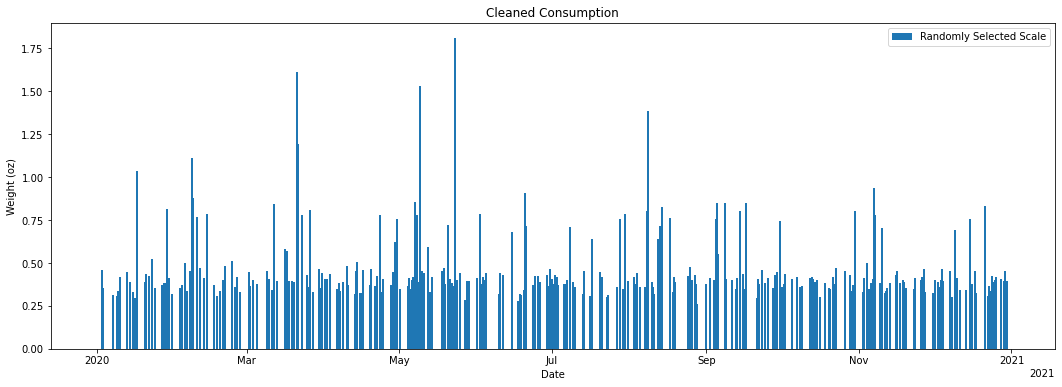

In [786]:
plot_weights(clean_consumption.index, clean_consumption.values, 'Cleaned Consumption', 'Randomly Selected Scale', bar = True)

#### Daily Frequency Analysis

In [1172]:
daily_consumption = clean_consumption.resample('1D').sum()

In [1173]:
stats = daily_consumption.describe()
print(stats)

count    365.000000
mean       0.407459
std        0.429524
min        0.000000
25%        0.000000
50%        0.388760
75%        0.705150
max        3.039608
Name: weight, dtype: float64


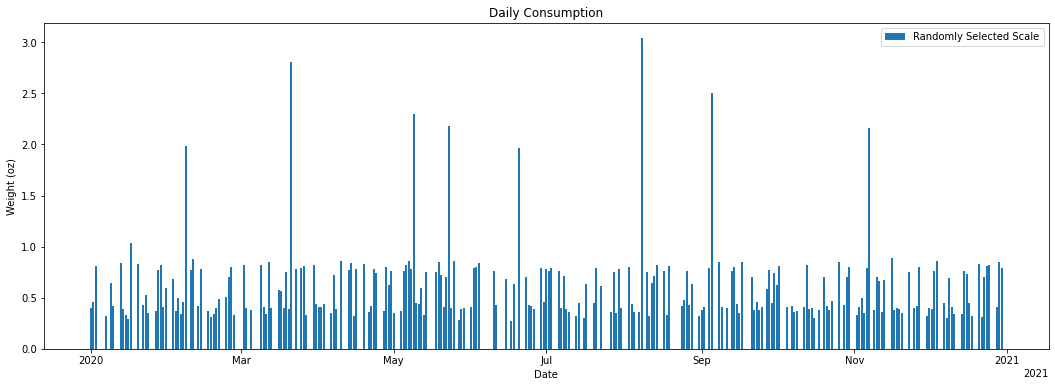

In [13]:
plot_weights(daily_consumption.index, daily_consumption.values, 'Daily Consumption', 'Randomly Selected Scale', bar = True)

#### Day of Week Analysis

In [814]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
day_of_week_mean = clean_consumption.groupby(clean_consumption.index.day_name()).mean().reindex(days)
groups_by_day_of_week = clean_consumption.groupby(clean_consumption.index.day_name())

data_with_dow = daily_consumption.copy().to_frame("consumption")
data_with_dow["day_of_week"] = data_with_dow.index.day_name()

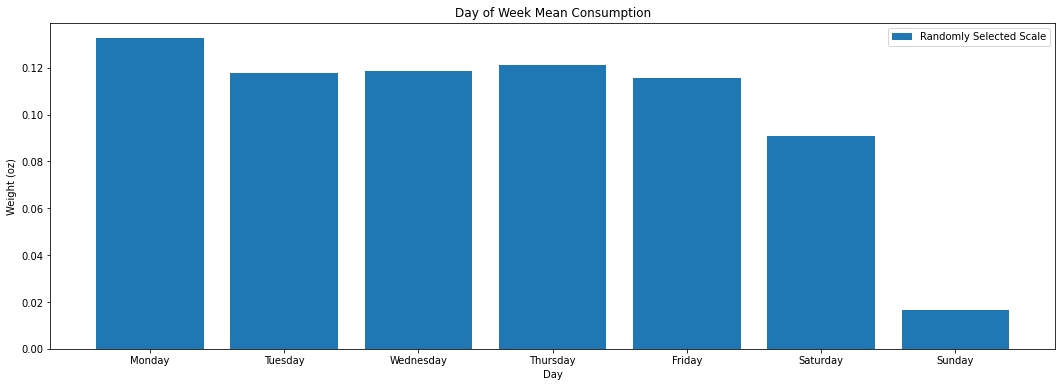

In [815]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(day_of_week_mean.index, day_of_week_mean.values, label='Randomly Selected Scale')
ax.set(xlabel='Day', ylabel='Weight (oz)', title='Day of Week Mean Consumption')
ax.legend()

Text(0.5, 0.98, 'Consumption Distribution of [Sample] by Day of Week')

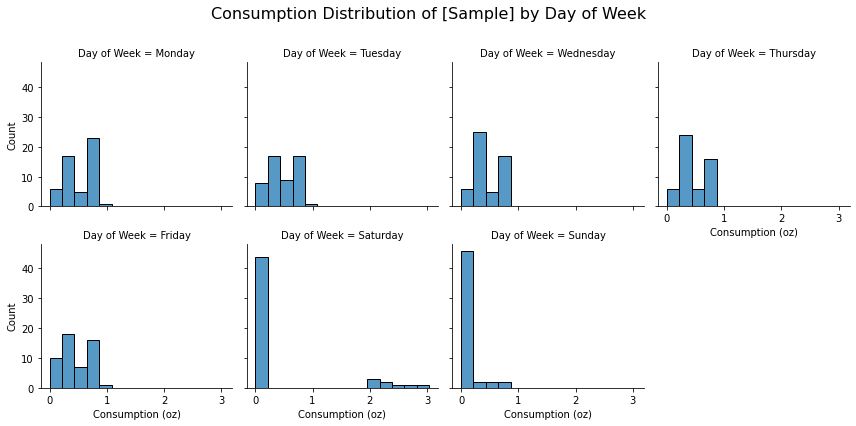

In [816]:
bins=np.linspace(data_with_dow['consumption'].min(), data_with_dow['consumption'].max(), 15)
ax = sns.displot(data_with_dow, x="consumption", col="day_of_week",col_wrap = 4, bins = bins, height=3, aspect=1, facet_kws=dict(col_order=days),)
ax.set_axis_labels("Consumption (oz)", "Count")
ax.set_titles(col_template="Day of Week = {col_name}")
ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle('Consumption Distribution of [Sample] by Day of Week', fontsize=16)

[Text(0.5, 0, 'Day of Week'),
 Text(0, 0.5, 'Consumption (oz)'),
 Text(0.5, 1.0, 'Consumption analysis of [Sample] by Day of Week')]

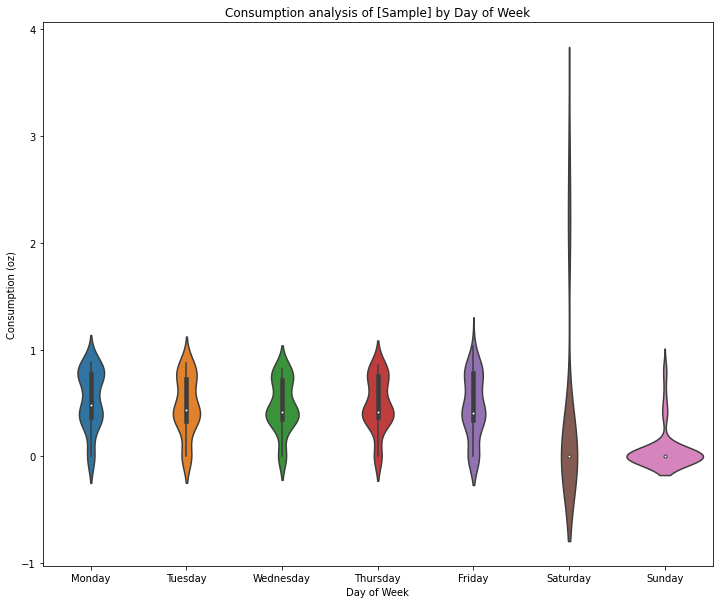

In [817]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.violinplot(x="day_of_week", y="consumption", data=data_with_dow, order=days)
ax.set(xlabel="Day of Week", ylabel="Consumption (oz)", title = 'Consumption analysis of [Sample] by Day of Week')

### Consumption Segments: Segments of consumption for single products 

Objective: Identify change points (resupply dates) to segment into individual product consumption periods.

In [59]:
import ruptures as rpt

In [542]:
def find_break_points(n_products, weight_series, window_width, model='l1'):
    algo = rpt.Window(width=window_width, model=model).fit(weight_series.values)
    break_points = algo.predict(n_bkps=n_products)
    return break_points

In [548]:
def find_peaks(weight_series: pd.Series):
    x = weight_series.values
    peaks = signal.find_peaks(x)[0]
    return peaks

In [593]:
sample_series = pd.Series(sample['weight'])

break_points = find_break_points(10, sample_series, 20, 'l1')
peaks = find_peaks(sample_series)

print(f"Break Points: {break_points}")
print(f"Peaks: {peaks}")

Break Points: [150, 305, 425, 530, 675, 820, 950, 1085, 1240, 1370, 1460]
Peaks: [ 152  306  424  532  676  818  950 1083 1238 1372]


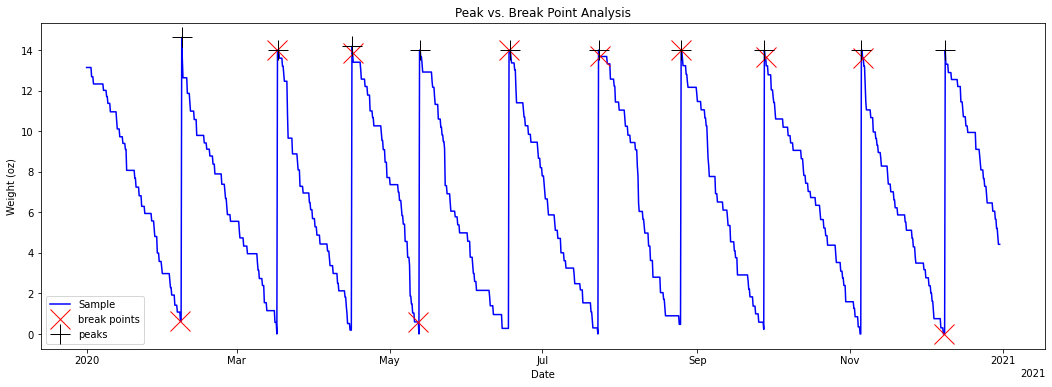

In [594]:
break_points.pop() # final break point is out of range 

dates = sample_series.index
weights = sample_series.values.reshape(-1)

break_points_dt = dates[break_points]
peaks_dt = dates[peaks]

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(dates, weights, color='blue', label = 'Sample')
ax.plot(dates[break_points], weights[break_points], "x", markersize = 20, color='red', label = 'break points')
ax.plot(dates[peaks], weights[peaks], "+", markersize = 20, color='black', label = 'peaks')
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set(xlabel='Date', ylabel='Weight (oz)', title="Peak vs. Break Point Analysis")
ax.legend()

#### Validate Segments

In [294]:
def create_consumption_segments(weights_series: pd.Series, break_points: list) -> dict:
    if break_points[-1] >= len(weights_series):
        break_points.pop()
    time_stamps = weights_series.index
    consumption_segments = {}
    
    start_index = 0
    end_index = break_points[0] - 1
    
    start_time_stamp = time_stamps[start_index]
    end_time_stamp = time_stamps[end_index]
    segment_0 = TimeWindow(start_time_stamp, end_time_stamp)
    
    consumption_segments[0] = segment_0
    
    for index, break_point in enumerate(break_points):
        start_index = break_point
        if index < len(break_points) - 1:
            end_index = break_points[index + 1] - 1
        else:
            end_index = -1
        start_time_stamp = time_stamps[start_index]
        end_time_stamp = time_stamps[end_index]

        consumption_segments[index + 1] = TimeWindow(start_time_stamp, end_time_stamp)

    return consumption_segments

        

In [590]:
def create_segment_data(segment: TimeWindow, weight_data: pd.Series) -> dict:
    segment_data = {}
    time_delta = segment.delta 
    start_time = segment.since
    end_time = segment.until
    start_weight = weight_data.loc[start_time]
    end_weight = weight_data.loc[end_time]
    max_weight = weight_data[start_time:end_time].max()
    min_weight = weight_data[start_time:end_time].min()
    max_weight_time = (weight_data[start_time:end_time].loc[weight_data[start_time:end_time] == max_weight]).index[0]
    min_weight_time = (weight_data[start_time:end_time].loc[weight_data[start_time:end_time] == min_weight]).index[-1]
    
    
    segment_data['time_delta'] = time_delta
    segment_data['start_time'] = start_time
    segment_data['end_time'] = end_time

    segment_data['start_weight'] = start_weight
    segment_data['end_weight'] = end_weight
    
    segment_data['max_weight'] = max_weight
    segment_data['min_weight'] = min_weight
    
    segment_data['max_weight_time'] = max_weight_time
    segment_data['min_weight_time'] = min_weight_time
    
    return segment_data

In [624]:
def create_segments_data(consumption_segments: dict, weight_data: pd.Series) -> pd.DataFrame:
    segments_data = pd.DataFrame.from_dict(consumption_segments, orient = 'index', columns = ['time_window'])
    segments_data['time_delta'] = [time_window.delta for time_window in segments_data['time_window']]
    segments_data['start_time'] = [time_window.since for time_window in segments_data['time_window']]
    segments_data['end_time'] = [time_window.until for time_window in segments_data['time_window']]

    segments_data['start_weight'] = [weight_data.loc[start_time] for start_time in segments_data['start_time']]
    segments_data['end_weight'] = [weight_data.loc[end_time] for end_time in segments_data['end_time']]
    
    segments_data['max_weight'] = [weight_data[row.start_time:row.end_time].max() for row in segments_data.itertuples()]
    segments_data['min_weight'] = [weight_data[row.start_time:row.end_time].min() for row in segments_data.itertuples()]
    
    segments_data['max_weight_time'] = [((weight_data[row.start_time:row.end_time].loc[weight_data[row.start_time:row.end_time] == row.max_weight]).index[0]) for row in segments_data.itertuples()]
    segments_data['min_weight_time'] = [((weight_data[row.start_time:row.end_time].loc[weight_data[row.start_time:row.end_time] == row.min_weight]).index[-1]) for row in segments_data.itertuples()]
    
    segments_data = segments_data[['time_delta','start_time', 'max_weight_time', 'end_time', 'min_weight_time', 'start_weight', 'max_weight', 'end_weight', 'min_weight']]
    
    return segments_data

In [625]:
def segements_misaligned(segments_data: pd.DataFrame) -> bool:
    misaligned = False
    for segment_index in segments_data.index:
        if segments_data.at[segment_index, 'start_time'] != segments_data.at[segment_index, 'max_weight_time']:
            misaligned = True
        if segments_data.at[segment_index, 'end_time'] != segments_data.at[segment_index, 'min_weight_time']:
            misaligned = True
        if segment_index < segments_data.index[-1]:
            if segments_data.at[segment_index, 'end_weight'] >= segments_data.at[segment_index + 1, 'start_weight']:
                misaligned = True
    return misaligned


In [677]:
def precise_segments(consumption_segments: dict, weight_series: pd.Series):
    
    segments = consumption_segments.copy()
    
    for segment_index in range(len(segments) - 1):
        current_segment_data = create_segment_data(segments[segment_index], weight_series)
        next_segment_data = create_segment_data(segments[segment_index + 1], weight_series)
        
        current_end_weight = current_segment_data['end_weight']
        next_start_weight = next_segment_data['start_weight']
        
        if current_end_weight >= next_start_weight:
            weight_sub_range = weight_series[current_segment_data['min_weight_time']: next_segment_data['end_time']]
            sub_range_values = np.array(weight_sub_range.values)
            sub_range_times = weight_sub_range.index
            peaks, plateus = signal.find_peaks(sub_range_values, plateau_size=1)
            first_maxima_index = peaks[0]
            if plateus['left_edges']:
                plateus_left_edge = plateus['left_edges']
                first_maxima_index = np.minimum(peaks, plateus_left_edge)[0]
            
            adjusted_current_end_time = sub_range_times[first_maxima_index - 1]
            adjusted_next_start_time = sub_range_times[first_maxima_index]

            adjusted_current_segment = TimeWindow(current_segment_data['start_time'], adjusted_current_end_time)
            adjusted_next_segment = TimeWindow(adjusted_next_start_time, next_segment_data['end_time'])

            segments[segment_index] = adjusted_current_segment
            segments[segment_index + 1] = adjusted_next_segment
        else:
            continue
    
    return segments

In [626]:
bkpt_segments = create_consumption_segments(sample_series, break_points)
peak_segments = create_consumption_segments(sample_series, peaks)

bkpt_segments_data = create_segments_data(bkpt_segments, sample_series)
peak_segments_data = create_segments_data(peak_segments, sample_series)

In [628]:
bkpt_misaligned = segements_misaligned(bkpt_segments_data)
print(f"\nBreak Point Segments Misaligned: {bkpt_misaligned}\n")
bkpt_segments_data


Break Point Segments Misaligned: True



,time_delta,start_time,max_weight_time,end_time,min_weight_time,start_weight,max_weight,end_weight,min_weight
0,37 days 06:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-02-07 06:00:00,2020-02-07 06:00:00,13.144815,13.144815,1.079715,1.079715
1,38 days 12:00:00,2020-02-07 12:00:00,2020-02-08 00:00:00,2020-03-17 00:00:00,2020-03-17 00:00:00,0.626084,14.626084,0.000000,0.000000
2,29 days 18:00:00,2020-03-17 06:00:00,2020-04-16 00:00:00,2020-04-16 00:00:00,2020-04-15 18:00:00,14.000000,14.189618,14.189618,0.189618
3,26 days 00:00:00,2020-04-16 06:00:00,2020-04-16 06:00:00,2020-05-12 06:00:00,2020-05-12 06:00:00,13.863917,13.863917,0.595371,0.595371
4,36 days 00:00:00,2020-05-12 12:00:00,2020-05-13 00:00:00,2020-06-17 12:00:00,2020-05-12 18:00:00,0.595371,14.000000,0.275799,0.000000
5,36 days 00:00:00,2020-06-17 18:00:00,2020-06-17 18:00:00,2020-07-23 18:00:00,2020-07-23 06:00:00,14.000000,14.000000,13.687529,0.000000
6,32 days 06:00:00,2020-07-24 00:00:00,2020-07-24 00:00:00,2020-08-25 06:00:00,2020-08-25 06:00:00,13.687529,13.687529,0.475203,0.475203
7,33 days 12:00:00,2020-08-25 12:00:00,2020-08-25 12:00:00,2020-09-28 00:00:00,2020-09-27 12:00:00,14.000000,14.000000,13.657577,0.224949
8,38 days 12:00:00,2020-09-28 06:00:00,2020-11-05 12:00:00,2020-11-05 18:00:00,2020-11-05 06:00:00,13.657577,14.000000,14.000000,0.000000
9,32 days 06:00:00,2020-11-06 00:00:00,2020-11-06 00:00:00,2020-12-08 06:00:00,2020-12-08 06:00:00,13.616803,13.616803,0.000000,0.000000


In [629]:
peaks_misaligned = segements_misaligned(peak_segments_data)
print(f"\nPeak Segments Misaligned: {peaks_misaligned}\n")
peak_segments_data


Peak Segments Misaligned: True



,time_delta,start_time,max_weight_time,end_time,min_weight_time,start_weight,max_weight,end_weight,min_weight
0,37 days 18:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-02-07 18:00:00,2020-02-07 18:00:00,13.144815,13.144815,0.626084,0.626084
1,38 days 06:00:00,2020-02-08 00:00:00,2020-02-08 00:00:00,2020-03-17 06:00:00,2020-03-17 00:00:00,14.626084,14.626084,14.000000,0.000000
2,29 days 06:00:00,2020-03-17 12:00:00,2020-03-17 12:00:00,2020-04-15 18:00:00,2020-04-15 18:00:00,14.000000,14.000000,0.189618,0.189618
3,26 days 18:00:00,2020-04-16 00:00:00,2020-04-16 00:00:00,2020-05-12 18:00:00,2020-05-12 18:00:00,14.189618,14.189618,0.000000,0.000000
4,35 days 18:00:00,2020-05-13 00:00:00,2020-05-13 00:00:00,2020-06-17 18:00:00,2020-06-17 12:00:00,14.000000,14.000000,14.000000,0.275799
5,35 days 06:00:00,2020-06-18 00:00:00,2020-06-18 00:00:00,2020-07-23 06:00:00,2020-07-23 06:00:00,14.000000,14.000000,0.000000,0.000000
6,32 days 18:00:00,2020-07-23 12:00:00,2020-07-23 12:00:00,2020-08-25 06:00:00,2020-08-25 06:00:00,14.000000,14.000000,0.475203,0.475203
7,33 days 00:00:00,2020-08-25 12:00:00,2020-08-25 12:00:00,2020-09-27 12:00:00,2020-09-27 12:00:00,14.000000,14.000000,0.224949,0.224949
8,38 days 12:00:00,2020-09-27 18:00:00,2020-09-27 18:00:00,2020-11-05 06:00:00,2020-11-05 06:00:00,14.000000,14.000000,0.000000,0.000000
9,33 days 06:00:00,2020-11-05 12:00:00,2020-11-05 12:00:00,2020-12-08 18:00:00,2020-12-08 18:00:00,14.000000,14.000000,0.000000,0.000000


In [678]:
bkpt_segments_fixed = precise_segments(bkpt_segments, sample_series)
peak_segments_fixed = precise_segments(peak_segments, sample_series)

bkpt_segments_data_fixed = create_segments_data(bkpt_segments_fixed, sample_series)
peak_segments_data_fixed = create_segments_data(peak_segments_fixed, sample_series)

In [679]:
bkpt_fixed_misaligned = segements_misaligned(bkpt_segments_data_fixed)
print(f"\nFixed Break Point Segments Misaligned: {bkpt_fixed_misaligned}\n")
bkpt_segments_data_fixed


Fixed Break Point Segments Misaligned: False



,time_delta,start_time,max_weight_time,end_time,min_weight_time,start_weight,max_weight,end_weight,min_weight
0,37 days 18:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-02-07 18:00:00,2020-02-07 18:00:00,13.144815,13.144815,0.626084,0.626084
1,38 days 00:00:00,2020-02-08 00:00:00,2020-02-08 00:00:00,2020-03-17 00:00:00,2020-03-17 00:00:00,14.626084,14.626084,0.000000,0.000000
2,29 days 12:00:00,2020-03-17 06:00:00,2020-03-17 06:00:00,2020-04-15 18:00:00,2020-04-15 18:00:00,14.000000,14.000000,0.189618,0.189618
3,26 days 18:00:00,2020-04-16 00:00:00,2020-04-16 00:00:00,2020-05-12 18:00:00,2020-05-12 18:00:00,14.189618,14.189618,0.000000,0.000000
4,35 days 12:00:00,2020-05-13 00:00:00,2020-05-13 00:00:00,2020-06-17 12:00:00,2020-06-17 12:00:00,14.000000,14.000000,0.275799,0.275799
5,35 days 12:00:00,2020-06-17 18:00:00,2020-06-17 18:00:00,2020-07-23 06:00:00,2020-07-23 06:00:00,14.000000,14.000000,0.000000,0.000000
6,32 days 18:00:00,2020-07-23 12:00:00,2020-07-23 12:00:00,2020-08-25 06:00:00,2020-08-25 06:00:00,14.000000,14.000000,0.475203,0.475203
7,33 days 00:00:00,2020-08-25 12:00:00,2020-08-25 12:00:00,2020-09-27 12:00:00,2020-09-27 12:00:00,14.000000,14.000000,0.224949,0.224949
8,38 days 12:00:00,2020-09-27 18:00:00,2020-09-27 18:00:00,2020-11-05 06:00:00,2020-11-05 06:00:00,14.000000,14.000000,0.000000,0.000000
9,33 days 06:00:00,2020-11-05 12:00:00,2020-11-05 12:00:00,2020-12-08 18:00:00,2020-12-08 18:00:00,14.000000,14.000000,0.000000,0.000000


In [680]:
peaks_fixed_misaligned = segements_misaligned(peak_segments_data_fixed)
print(f"\nFixed Peak Segments Misaligned: {peaks_fixed_misaligned}\n")
peak_segments_data_fixed


Fixed Peak Segments Misaligned: False



,time_delta,start_time,max_weight_time,end_time,min_weight_time,start_weight,max_weight,end_weight,min_weight
0,37 days 18:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-02-07 18:00:00,2020-02-07 18:00:00,13.144815,13.144815,0.626084,0.626084
1,38 days 00:00:00,2020-02-08 00:00:00,2020-02-08 00:00:00,2020-03-17 00:00:00,2020-03-17 00:00:00,14.626084,14.626084,0.000000,0.000000
2,29 days 12:00:00,2020-03-17 06:00:00,2020-03-17 06:00:00,2020-04-15 18:00:00,2020-04-15 18:00:00,14.000000,14.000000,0.189618,0.189618
3,26 days 18:00:00,2020-04-16 00:00:00,2020-04-16 00:00:00,2020-05-12 18:00:00,2020-05-12 18:00:00,14.189618,14.189618,0.000000,0.000000
4,35 days 12:00:00,2020-05-13 00:00:00,2020-05-13 00:00:00,2020-06-17 12:00:00,2020-06-17 12:00:00,14.000000,14.000000,0.275799,0.275799
5,35 days 12:00:00,2020-06-17 18:00:00,2020-06-17 18:00:00,2020-07-23 06:00:00,2020-07-23 06:00:00,14.000000,14.000000,0.000000,0.000000
6,32 days 18:00:00,2020-07-23 12:00:00,2020-07-23 12:00:00,2020-08-25 06:00:00,2020-08-25 06:00:00,14.000000,14.000000,0.475203,0.475203
7,33 days 00:00:00,2020-08-25 12:00:00,2020-08-25 12:00:00,2020-09-27 12:00:00,2020-09-27 12:00:00,14.000000,14.000000,0.224949,0.224949
8,38 days 12:00:00,2020-09-27 18:00:00,2020-09-27 18:00:00,2020-11-05 06:00:00,2020-11-05 06:00:00,14.000000,14.000000,0.000000,0.000000
9,33 days 06:00:00,2020-11-05 12:00:00,2020-11-05 12:00:00,2020-12-08 18:00:00,2020-12-08 18:00:00,14.000000,14.000000,0.000000,0.000000


#### Analyze consumption rates for each segment

In [746]:
def segment_consumption_stats(segments, weight_series):
    segments_data = create_segments_data(segments, weight_series)
    clean_consumption = calculate_consumption(weight_series)
    daily_consumption = clean_consumption.resample('1D').sum()
    segments_stats_dict = {}
    for segment in segments_data.itertuples():
        segment_consumption = daily_consumption[segment.start_time: segment.end_time]
        segment_stats = segment_consumption.describe()
        segments_stats_dict[segment.Index] = segment_stats.to_dict()
    
    stats_df = pd.DataFrame.from_dict(segments_stats_dict).T
    segments_stats = segments_data[['time_delta', 'start_time', 'end_time']]
    segments_stats = pd.concat([segments_stats, stats_df], axis=1)

    return segments_stats

In [750]:
segments_stats = segment_consumption_stats(peak_segments_fixed, sample_series)
segments_stats

,time_delta,start_time,end_time,count,mean,std,min,25%,50%,75%,max
0,37 days 18:00:00,2020-01-01 00:00:00,2020-02-07 18:00:00,38.0,0.329440,0.316646,0.0,0.000000,0.345279,0.517144,1.033988
1,38 days 00:00:00,2020-02-08 00:00:00,2020-03-17 00:00:00,39.0,0.375028,0.407378,0.0,0.000000,0.369491,0.575329,1.988914
2,29 days 12:00:00,2020-03-17 06:00:00,2020-04-15 18:00:00,29.0,0.476220,0.550591,0.0,0.000000,0.395173,0.770927,2.807516
3,26 days 18:00:00,2020-04-16 00:00:00,2020-05-12 18:00:00,27.0,0.525541,0.477599,0.0,0.174862,0.452132,0.780332,2.296751
4,35 days 12:00:00,2020-05-13 00:00:00,2020-06-17 12:00:00,36.0,0.388889,0.451734,0.0,0.000000,0.361190,0.729070,2.175321
5,35 days 12:00:00,2020-06-17 18:00:00,2020-07-23 06:00:00,36.0,0.397569,0.405915,0.0,0.000000,0.396421,0.655398,1.966915
6,32 days 18:00:00,2020-07-23 12:00:00,2020-08-25 06:00:00,33.0,0.414774,0.566048,0.0,0.000000,0.361024,0.712998,3.039608
7,33 days 00:00:00,2020-08-25 12:00:00,2020-09-27 12:00:00,33.0,0.424242,0.478539,0.0,0.000000,0.399260,0.638862,2.500302
8,38 days 12:00:00,2020-09-27 18:00:00,2020-11-05 06:00:00,39.0,0.358974,0.285686,0.0,0.000000,0.389737,0.485553,0.853801
9,33 days 06:00:00,2020-11-05 12:00:00,2020-12-08 18:00:00,33.0,0.424242,0.430913,0.0,0.000000,0.388760,0.668963,2.156088


In [791]:
consumption_analysis = daily_consumption.copy().to_frame("consumption")
consumption_analysis['consumption_segment'] = np.nan

for row in segments_stats.itertuples():
    consumption_analysis.at[row.start_time:row.end_time, 'consumption_segment'] = int(row.Index)


[Text(0.5, 0, 'Consumption Segment'),
 Text(0, 0.5, 'Consumption (oz)'),
 Text(0.5, 1.0, 'Consumption analysis of [Sample] by Segment')]

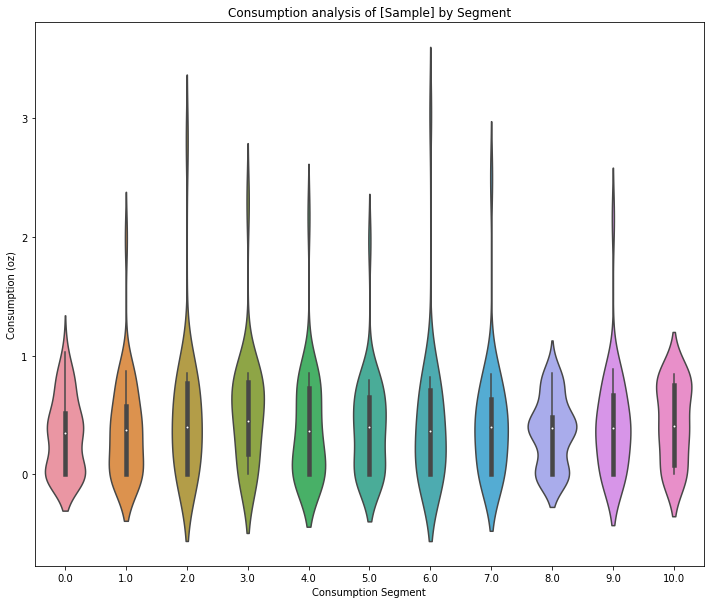

In [790]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.violinplot(x="consumption_segment", y="consumption", data=consumption_analysis)
ax.set(xlabel="Consumption Segment", ylabel="Consumption (oz)", title = 'Consumption analysis of [Sample] by Segment')

### Analyze consumption rates for rolling 3, 7, 10, 14, 21 day & alltime averages

In [795]:
consumption_rolling_analysis = daily_consumption.copy().to_frame("consumption")
consumption_rolling_analysis['3D_SMA'] = consumption_rolling_analysis.loc[:, 'consumption'].rolling(window='3D').mean()
consumption_rolling_analysis['7D_SMA'] = consumption_rolling_analysis.loc[:, 'consumption'].rolling(window='7D').mean()
consumption_rolling_analysis['14D_SMA'] = consumption_rolling_analysis.loc[:, 'consumption'].rolling(window='14D').mean()
consumption_rolling_analysis['21D_SMA'] = consumption_rolling_analysis.loc[:, 'consumption'].rolling(window='21D').mean()
consumption_rolling_analysis['30D_SMA'] = consumption_rolling_analysis.loc[:, 'consumption'].rolling(window='30D').mean()

In [796]:
consumption_rolling_analysis

,consumption,3D_SMA,7D_SMA,14D_SMA,21D_SMA,30D_SMA
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.811885,0.270628,0.270628,0.270628,0.270628,0.270628
2020-01-04,0.000000,0.270628,0.202971,0.202971,0.202971,0.202971
2020-01-05,0.000000,0.270628,0.162377,0.162377,0.162377,0.162377
...,...,...,...,...,...,...
2020-12-26,0.000000,0.542614,0.496664,0.434777,0.394807,0.394387
2020-12-27,0.000000,0.272722,0.496664,0.434777,0.394807,0.367741
2020-12-28,0.407168,0.135723,0.435744,0.439308,0.392627,0.381313
2020-12-29,0.846739,0.417969,0.512521,0.445605,0.418567,0.409538


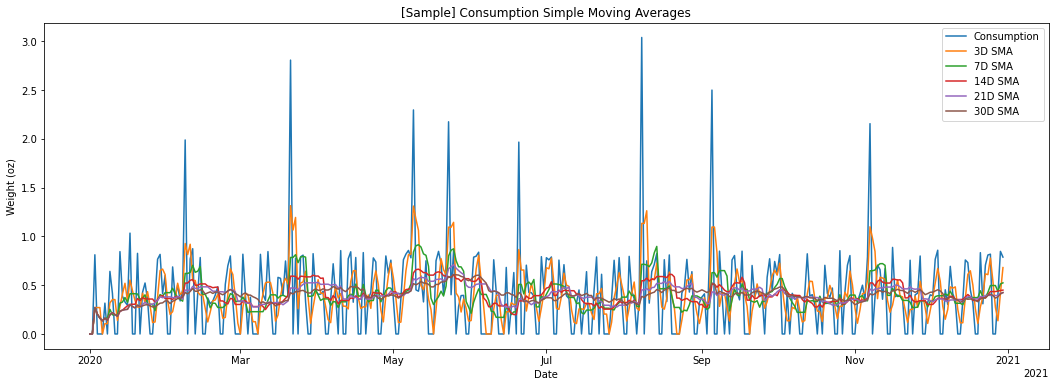

In [1342]:
dates = consumption_rolling_analysis.index

days = mdates.WeekdayLocator()
months = mdates.MonthLocator()
years = mdates.YearLocator()  
months_fmt = mdates.DateFormatter('%m')

fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(dates, consumption_rolling_analysis['consumption'], label = 'Consumption')
ax.plot(dates, consumption_rolling_analysis['3D_SMA'], label = '3D SMA')
ax.plot(dates, consumption_rolling_analysis['7D_SMA'], label = '7D SMA')
ax.plot(dates, consumption_rolling_analysis['14D_SMA'], label = '14D SMA')
ax.plot(dates, consumption_rolling_analysis['21D_SMA'], label = '21D SMA')
ax.plot(dates, consumption_rolling_analysis['30D_SMA'], label = '30D SMA')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set(xlabel='Date', ylabel='Weight (oz)', title='[Sample] Consumption Simple Moving Averages')
ax.legend()


In [803]:
consumption_rolling_analysis.describe()

,consumption,3D_SMA,7D_SMA,14D_SMA,21D_SMA,30D_SMA
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.407459,0.405247,0.403836,0.400814,0.398866,0.397252
std,0.429524,0.245031,0.156125,0.113364,0.095714,0.081325
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.253844,0.314273,0.329049,0.337319,0.353706
50%,0.388760,0.377040,0.378105,0.371069,0.389148,0.403108
75%,0.705150,0.532329,0.450272,0.480797,0.464638,0.441191
max,3.039608,1.315239,0.914895,0.664170,0.711484,0.606904


[Text(0.5, 0, 'SMA Size'),
 Text(0, 0.5, 'Consumption (oz)'),
 Text(0.5, 1.0, '[Sample] Consumption Simple Moving Averages')]

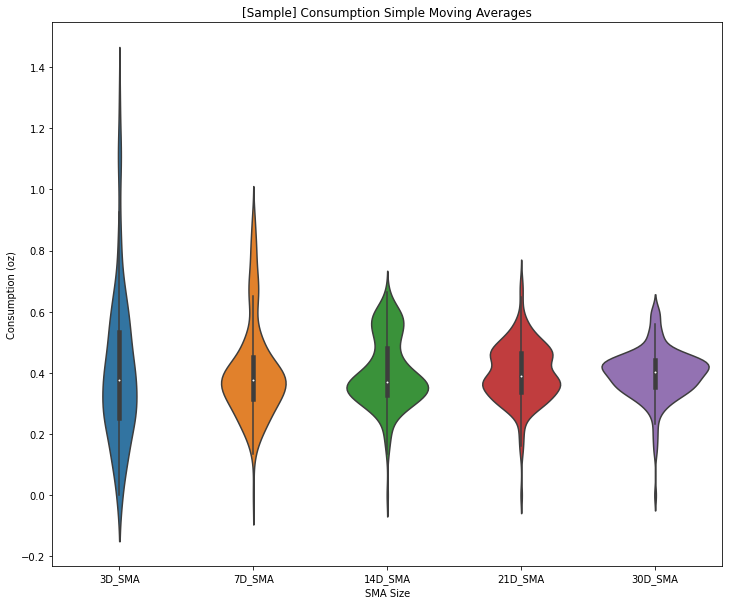

In [811]:
rolling_averages = consumption_rolling_analysis.drop(columns = ['consumption'])
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.violinplot(data=rolling_averages)
ax.set(xlabel="SMA Size", ylabel="Consumption (oz)", title = '[Sample] Consumption Simple Moving Averages')

# Analysis hypothesis
####  1. Simply checking when scales go to zero isn’t effective because of scale noise
####  2. Using mean-time-to-bag-zero results in low accuracy for predicting the time they finish a bag
####  3. Can predict when customer finishes a bag by fitting a straight line to the last N measurements
####  4. Ship bags way more often than you need to to make customers happy
    - Average consumption * timespan yields X amount of bags vs. actual
    - Show what dates the bags would be sent and the weights
    - If a selected schedule, show as well


#### Need to solidify a metric for the model
- Delta between forecast and actual?

In [915]:
total_consumption =  consumption_rolling_analysis.consumption.sum()
mean_daily_consumption = consumption_rolling_analysis.consumption.mean()
total_duration = pd.Timedelta(consumption_rolling_analysis.index[-1] - consumption_rolling_analysis.index[-0]) / pd.Timedelta('1D')
total_averaged_consumption = mean_daily_consumption * total_duration
single_bag_weight = 14
mean_bag_duration = single_bag_weight / mean_daily_consumption

In [916]:
print(f"Total Consumption: {total_consumption}\nTotal Averaged Consumption: {total_averaged_consumption}")

Total Consumption: 148.72259922021226
Total Averaged Consumption: 148.31514004426649


In [917]:
print(f"Mean bag duration: {mean_bag_duration}")

Mean bag duration: 34.35927039194405


In [918]:
sample_file_path = weights_file_list
sample_file_name = sample_file_path.stem
sample_file_name_split = sample_file_name.split('_')
simulation_uuid = sample_file_name_split[0]

servings_file_names = [file.name for file in servings_file_list]
servings_match = [file_name for file_name in servings_file_names if simulation_uuid in file_name] 

In [919]:
servings_match

['4b95c80b-b49a-44ac-8ea1-bb50ff12b222_upsampled.csv',
 '4b95c80b-b49a-44ac-8ea1-bb50ff12b222_daily.csv']

In [1018]:
daily_consumption_file = servings_match[1]
file_path = servings_path / daily_consumption_file 
consumer_behavior = pd.read_csv(file_path, parse_dates=True, index_col=0)

In [990]:
consumer_behavior.head()

,servings
2020-01-01,1
2020-01-02,1
2020-01-03,2
2020-01-04,0
2020-01-05,0


In [922]:
quantity_to_weight = (random.normalvariate, (0.38, 0.05))

In [1019]:
def create_desired_consumption(servings, quantity_to_weight):
    conversion_fn = quantity_to_weight[0]
    fn_inputs = quantity_to_weight[1]
    desired_consumption = pd.Series(0, index =servings.index, dtype=float, name='desired_consumption')
    for timestep in desired_consumption.index:
        step_servings = servings[timestep]
        quantity_weight = conversion_fn(*fn_inputs)
        step_desired_consumption = (step_servings*quantity_weight)
        desired_consumption[timestep] = step_desired_consumption
    return desired_consumption

In [1049]:
def linear_initial_weights(desired_consumption, delivery_frequency, bag_weight):
    weights = pd.Series(0, index=desired_consumption.index, dtype=float, name='weight')
    delivery_frequency = str(int(delivery_frequency)) + 'D'
    first_day = desired_consumption.index[0]
    last_day = desired_consumption.index[-1]    
    delivery_dates = pd.date_range(first_day, last_day, freq = delivery_frequency)
    weights[delivery_dates] = bag_weight
    return weights

In [1125]:
def classify_dates(weight_series, bag_weight):
    fresh = weight_series.index[(weight_series > 0) & (weight_series < bag_weight)]
    stale = weight_series.index[(weight_series > bag_weight)]
    unavailable = weight_series.index[(weight_series == 0)]
    classifications = pd.Series('unavailable', index=weight_series.index, dtype=str, name='day_classification')
    classifications[fresh] = 'fresh'
    classifications[stale] = 'stale'
    classifications[unavailable] = 'unavailable'
    return classifications

In [1128]:
def create_linear_data(servings_series, quantity_to_weight, bag_weight, delivery_frequency):
    
    desired_consumption = create_desired_consumption(servings_series, quantity_to_weight)
    initial_weights = linear_initial_weights(desired_consumption, delivery_frequency, bag_weight)
 
    desired_consumption = desired_consumption.rename('desired_consumption')
    initial_scale_weight = initial_weights.rename('weight')
    linear_data = pd.concat([desired_consumption, initial_scale_weight], axis=1)
    linear_data['actual_consumption'] = 0.0
    
    day_end_weight = 0
    
    for day in  linear_data.index:
        day_start_weight = linear_data.at[day, 'weight'] + day_end_weight
        day_consumption = linear_data.at[day, 'desired_consumption']
        if day_start_weight == 0:
            day_consumption = 0
        else:
            day_consumption = min(day_consumption, day_start_weight)
        day_end_weight = day_start_weight - day_consumption
        linear_data.at[day, 'weight'] = day_end_weight 
        linear_data.at[day, 'actual_consumption'] = day_consumption
        
    day_classifications = classify_dates(linear_data.weight, bag_weight)
    linear_data = pd.concat([linear_data, day_classifications], axis=1)
    return linear_data

In [1129]:
consumer_behavior = pd.read_csv(file_path, parse_dates=True, index_col=0)
quantity_to_weight = (random.normalvariate, (0.38, 0.05))

linear_28D_data = create_linear_data(consumer_behavior.servings, quantity_to_weight, 14, 28)
linear_35D_data = create_linear_data(consumer_behavior.servings, quantity_to_weight, 14, 35)
linear_42D_data = create_linear_data(consumer_behavior.servings, quantity_to_weight, 14, 42)

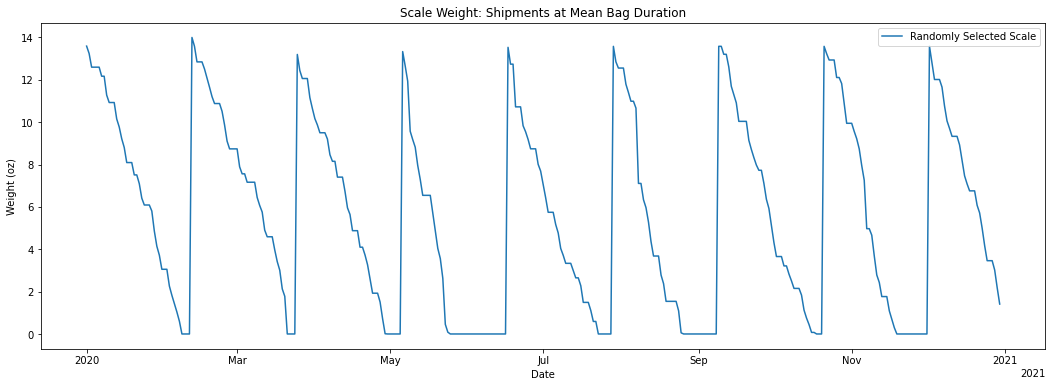

In [1083]:
plot_weights(linear_42D_data.index, linear_42D_data.weight, 'Scale Weight: Shipments at Mean Bag Duration', 'Randomly Selected Scale', bar = False)

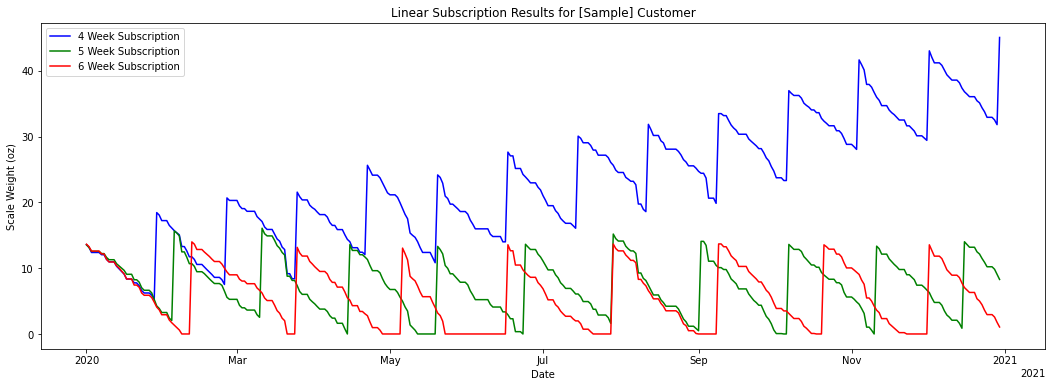

In [1156]:
dates = consumer_behavior.index

days = mdates.WeekdayLocator()
months = mdates.MonthLocator()
years = mdates.YearLocator()  
months_fmt = mdates.DateFormatter('%m')

fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(dates, linear_28D_data.weight, label = '4 Week Subscription', color='blue')
ax.plot(dates, linear_35D_data.weight, label = '5 Week Subscription', color='green')
ax.plot(dates, linear_42D_data.weight, label = '6 Week Subscription', color='red')


locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set(xlabel='Date', ylabel='Scale Weight (oz)', title='Linear Subscription Results for [Sample] Customer')
ax.legend()


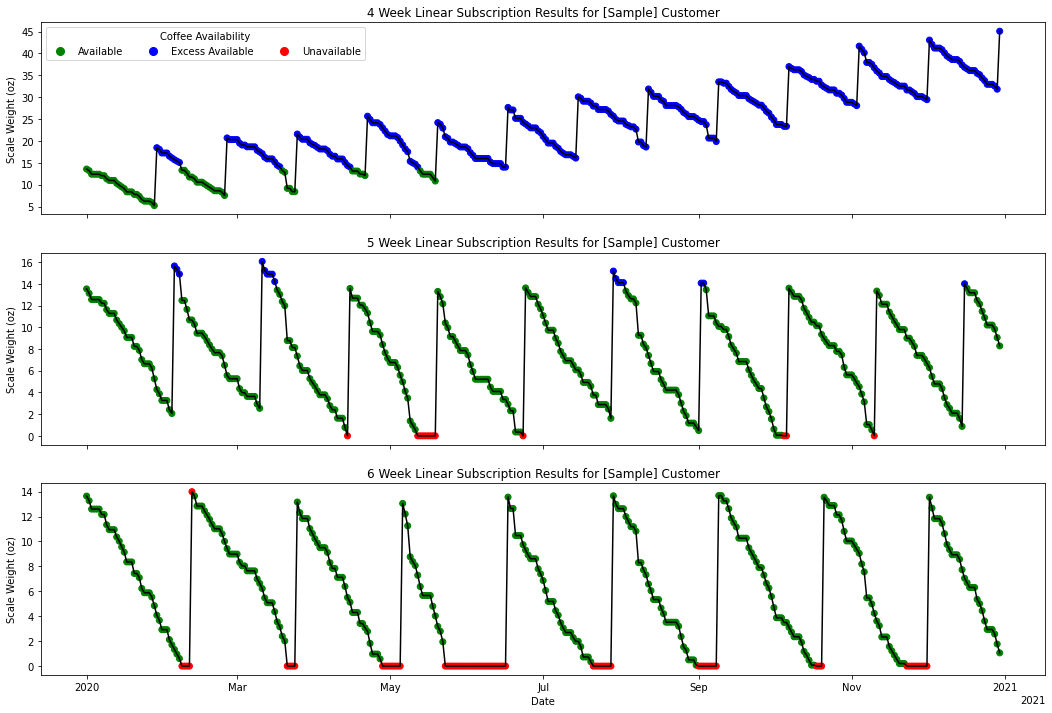

In [1507]:
dates = consumer_behavior.index

days = mdates.WeekdayLocator()
months = mdates.MonthLocator()
years = mdates.YearLocator()  
months_fmt = mdates.DateFormatter('%m')

colors ={'fresh': 'green', 'stale': 'blue', 'unavailable': 'red'}
fresh_marker = matplotlib.lines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=8, label='Available')
stale_marker = matplotlib.lines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, label='Excess Available')
unavailable_marker = matplotlib.lines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Unavailable')

fig, ax = plt.subplots(3,1, sharex=True, figsize=(18, 12))

ax[0].legend(handles=[fresh_marker, stale_marker, unavailable_marker], title = 'Coffee Availability', ncol =3)

ax[0].plot(dates, linear_28D_data.weight, label = '4 Week Subscription', color='black')
ax[0].scatter(dates, linear_28D_data.weight, label = '4 Week Subscription', color=linear_28D_data.day_classification.map(colors))
ax[1].plot(dates, linear_35D_data.weight, label = '5 Week Subscription', color='black')
ax[1].scatter(dates, linear_35D_data.weight, label = '4 Week Subscription', color=linear_35D_data.day_classification.map(colors))
ax[2].plot(dates, linear_42D_data.weight, label = '6 Week Subscription', color='black')
ax[2].scatter(dates, linear_42D_data.weight, label = '4 Week Subscription', color=linear_42D_data.day_classification.map(colors))


locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax[0].set(ylabel='Scale Weight (oz)', title='4 Week Linear Subscription Results for [Sample] Customer')
ax[1].set(ylabel='Scale Weight (oz)', title='5 Week Linear Subscription Results for [Sample] Customer')
ax[2].set(xlabel='Date', ylabel='Scale Weight (oz)', title='6 Week Linear Subscription Results for [Sample] Customer')
ax[2].xaxis.set_major_formatter(formatter)

In [1158]:
# TODO: plot colored by category https://stackoverflow.com/questions/31590184/plot-multicolored-line-based-on-conditional-in-python

# Forecast Weight

In [1437]:
import sklearn

In [1363]:
# create test and train data
# for each time stamp (t), train = data_0 - data_t-1, test = data_t + forecast_size - 1

def create_train_test_splits(consumption_series, forecast_size):
    available_dates = consumption_series.index[1:-forecast_size + 1]
    datasets = {}
    for d_idx, day in enumerate(available_dates):
        train = consumption_series[0: d_idx + 1]
        test = consumption_series[d_idx + 1 : d_idx + forecast_size + 1]
        train_test = {'train':train,'test':test}
        datasets[day] = train_test
    return datasets

In [1414]:
def sma_predict(averaging_window, x, y_dates):
    sma = x.rolling(averaging_window, min_periods=1).mean()[-1]
    predictions = pd.Series(sma, index = y_dates, dtype=float, name='pred')
    return predictions

In [1429]:
def sma_predict_all(train_test_splits_dict, averaging_window):
    predict_dates_list = list(train_test_splits_dict.keys())
    all_predictions = {}
    for date in predict_dates_list:
        x = train_test_splits_dict[date]['train']
        y_true = train_test_splits_dict[date]['test']
        y_dates = y_true.index
        y_pred = sma_predict(averaging_window, x, y_dates)
        all_predictions[date] = y_pred
    return all_predictions

In [1438]:
def create_test_weight_vals(start_weight, consumption_series):
    weights = pd.Series(start_weight, index=consumption_series.index, dtype=float, name='weight')
    for day in weights.index:
        weights[day:]-= consumption_series[day]
    return weights

In [1439]:
def create_test_binary_vals(start_weight, consumption_series):
    scale_weight_positive = create_test_weight_val(start_weight, consumption_series)
    scale_weight_positive[scale_weight_positive<=0] = 0
    scale_weight_positive[scale_weight_positive>0] = 1
    return scale_weight_positive

In [1526]:
def sma_single_test(full_weight_series, consumption_series_train, consumption_series_test, sma_window):
    data_dict ={}
    train_dates = consumption_series_train.index
    test_dates = consumption_series_test.index
    
    train_weights = full_weight_series[train_dates]
    start_weight = train_weights[-1]
    test_theoretical_weight = create_test_weight_vals(start_weight, consumption_series_test)
    test_theoretical_binary = create_test_binary_vals(start_weight, consumption_series_test)
    
    pred_consumption = sma_predict(sma_window, consumption_series_train, test_dates)
    pred_weight = create_test_weight_vals(start_weight, pred_consumption)
    pred_binary = create_test_binary_vals(start_weight, pred_consumption)
    
    data_dict['train_weight'] = train_weights
    data_dict['train_consumption'] = consumption_series_train
    data_dict['test_weight'] = test_theoretical_weight
    data_dict['test_consumption'] = consumption_series_test
    data_dict['test_binary'] = test_theoretical_binary
    data_dict['pred_weight'] = pred_weight
    data_dict['pred_consumption'] = pred_consumption
    data_dict['pred_binary'] = pred_binary
    
    return data_dict

In [1547]:
def sma_multi_test(full_weight_series, train_test_dict, sma_window):
    all_tests_dict = {}
    pred_dates = list(train_test_dict.keys())
    for day in pred_dates:
        day_train_test = train_test_dict[day]
        consumption_series_train = day_train_test['train']
        consumption_series_test = day_train_test['test']
        day_pred_dict = sma_single_test(full_weight_series, consumption_series_train, consumption_series_test, sma_window)
        all_tests_dict[day] = day_pred_dict
        
    return all_tests_dict

In [1554]:
def plot_forecast_results(pred_date, train_consumption, test_consumption, pred_consumption, train_weight, test_weight, pred_weight, test_binary, pred_binary, model_name, forecast_days_int):

    days = mdates.WeekdayLocator()
    months = mdates.MonthLocator()
    years = mdates.YearLocator()  
    months_fmt = mdates.DateFormatter('%m')
    
    date = pred_date.strftime('%B %d, %Y')

    fig, ax = plt.subplots(3,1, figsize=(18, 12))

    ax[0].plot(train_consumption.index, train_consumption.values, label = 'Train', color='blue')
    ax[0].plot(test_consumption.index, test_consumption.values, label = 'Test: True', color='green')
    ax[0].plot(pred_consumption.index, pred_consumption.values, label = f'Test: {model_name} Forecast', color='red')
    ax[0].set(ylabel='Consumption (oz)', title=f'{forecast_days_int} Day Consumption Forecast of [Sample] Customer on {date}')
    ax[0].legend()

    ax[1].plot(train_weight.index, train_weight.values, label = 'Train', color='blue')
    ax[1].plot(test_weight.index, test_weight.values, label = 'Test: True', color='green')
    ax[1].plot(pred_weight.index, pred_weight.values, label = f'Test: {model_name} Forecast', color='red')
    ax[1].set(ylabel='Scale Weight (oz)', title=f'{forecast_days_int} Day Scale Weight Forecast of [Sample] Customer on {date}')

    ax[2].plot(test_binary.index, test_binary.values, label = 'Test: True', color='green')
    ax[2].plot(pred_binary.index, pred_binary.values, label = f'Test: {model_name} Forecast', color='red')
    ax[2].set(xlabel = 'Date', ylabel='Scale Weight Above (0) oz', title=f'{forecast_days_int} Day Positive Scale Weight Forecast of [Sample] Customer on {date}')
    ax[2].set_yticks([0,1])

    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)

    ax[0].xaxis.set_major_formatter(formatter)
    ax[1].xaxis.set_major_formatter(formatter)
    ax[2].xaxis.set_major_formatter(formatter)

In [1553]:
model_name = '7 Day SMA'
num_days_forecast = 7
test_dict_full = sma_multi_test(full_weight_series = eod_weight.weight, train_test_dict = train_test_splits_dict, sma_window = '7D')
test_dict_full_keys = list(test_dict_full.keys())
sample_pred_date = test_dict_full_keys[32]
sample_test_dict = test_dict_full[sample_pred_date]

sample_train_weight = sample_test_dict['train_weight']
sample_train_consumption = sample_test_dict['train_consumption']
sample_test_weight = sample_test_dict['test_weight']
sample_test_consumption = sample_test_dict['test_consumption']
sample_test_binary = sample_test_dict['test_binary']
sample_pred_weight = sample_test_dict['pred_weight']
sample_pred_consumption = sample_test_dict['pred_consumption']
sample_pred_binary = sample_test_dict['pred_binary']

In [1563]:
sample_train_weight[-7:]

2020-01-27    5.573736
2020-01-28    4.807459
2020-01-29    3.991708
2020-01-30    3.578500
2020-01-31    2.978808
2020-02-01    2.978808
2020-02-02    2.978808
Freq: D, Name: weight, dtype: float64

In [1562]:
sample_train_consumption[-7:]

2020-01-27    0.369891
2020-01-28    0.766278
2020-01-29    0.815751
2020-01-30    0.413208
2020-01-31    0.599691
2020-02-01    0.000000
2020-02-02    0.000000
Freq: D, Name: consumption, dtype: float64

In [1565]:
sample_test_consumption

2020-02-03    0.687280
2020-02-04    0.372176
2020-02-05    0.500758
2020-02-06    0.338878
2020-02-07    0.453631
2020-02-08    1.988914
2020-02-09    0.000000
Freq: D, Name: consumption, dtype: float64

In [1564]:
sample_test_weight

2020-02-03    2.291528
2020-02-04    1.919352
2020-02-05    1.418594
2020-02-06    1.079715
2020-02-07    0.626084
2020-02-08   -1.362830
2020-02-09   -1.362830
Freq: D, Name: weight, dtype: float64

In [1566]:
sample_test_binary

2020-02-03    1.0
2020-02-04    1.0
2020-02-05    1.0
2020-02-06    1.0
2020-02-07    1.0
2020-02-08    0.0
2020-02-09    0.0
Freq: D, Name: weight, dtype: float64

In [1568]:
sample_pred_consumption

2020-02-03    0.423546
2020-02-04    0.423546
2020-02-05    0.423546
2020-02-06    0.423546
2020-02-07    0.423546
2020-02-08    0.423546
2020-02-09    0.423546
Freq: D, Name: pred, dtype: float64

In [1567]:
sample_pred_weight

2020-02-03    2.555263
2020-02-04    2.131717
2020-02-05    1.708172
2020-02-06    1.284626
2020-02-07    0.861080
2020-02-08    0.437535
2020-02-09    0.013989
Freq: D, Name: weight, dtype: float64

In [1569]:
sample_pred_binary

2020-02-03    1.0
2020-02-04    1.0
2020-02-05    1.0
2020-02-06    1.0
2020-02-07    1.0
2020-02-08    1.0
2020-02-09    1.0
Freq: D, Name: weight, dtype: float64

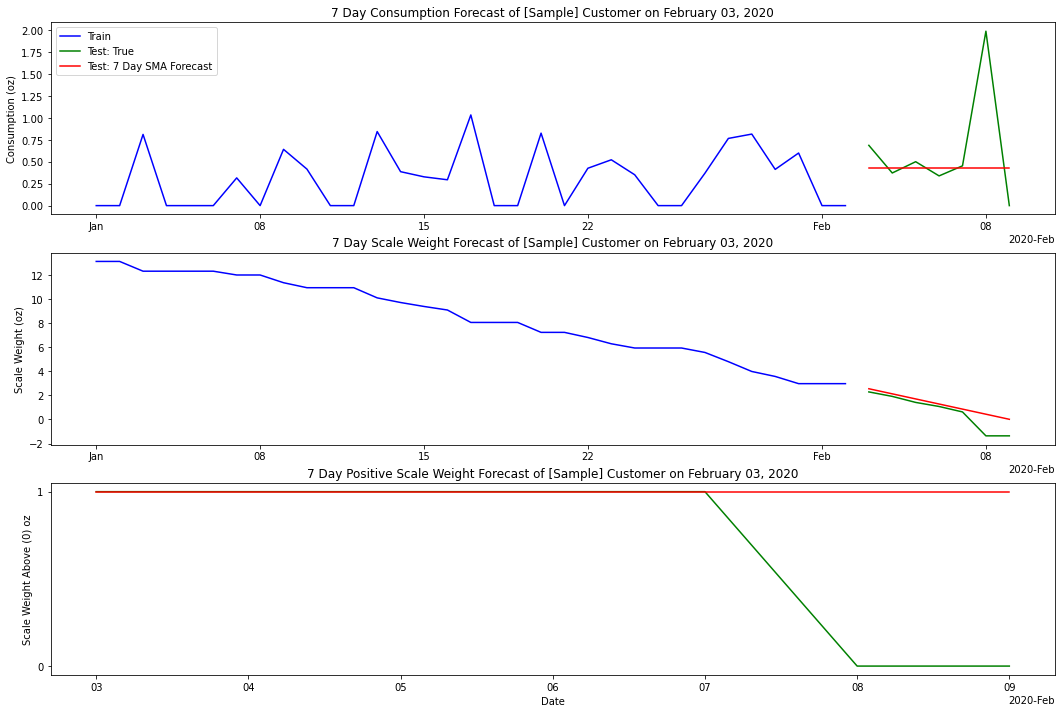

In [1555]:
plot_forecast_results(pred_date = sample_pred_date, 
                      train_consumption = sample_train_consumption, 
                      test_consumption = sample_test_consumption, 
                      pred_consumption = sample_pred_consumption,
                      train_weight = sample_train_weight, 
                      test_weight = sample_test_weight, 
                      pred_weight = sample_pred_weight, 
                      test_binary = sample_test_binary, 
                      pred_binary = sample_pred_binary, 
                      model_name = model_name, 
                      forecast_days_int = num_days_forecast)

# calculate scoring metrics

## Classification Metrics: Confusion Matrix, Precision & Recall, Accuracy, Logarithmic Loss, ROC & AUC

### Single Test Example

In [1570]:
y_true = sample_test_binary.values
y_pred = sample_pred_binary.values

#### Confusion Matrix, Type 1 Error (FPR), Type 2 Error (FNR)

In [1571]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)

print(f"confusion matrix:\n{cm}\n\nfalse positive rate: {false_positive_rate}\n\nfalse negative rate: {false_negative_rate}")

# TODO create standard CM plot for the project

confusion matrix:
[[0 2]
 [0 5]]

false positive rate: 1.0

false negative rate: 0.0


#### Precision & Recall

In [1572]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, labels=[0,1]) # tp / (tp + fn)
recall = recall_score(y_true, y_pred, labels=[0,1]) # tp/ (tp + fp)
print(f"precision: {precision}\nrecall: {recall}")

precision: 0.7142857142857143
recall: 1.0


#### Accuracy

In [1573]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred) # (tp + tn) / (tp + fp + fn + tn)
print(f"accuracy: {accuracy}")

accuracy: 0.7142857142857143


#### Log Loss

In [1574]:
from sklearn.metrics import log_loss as ll
log_loss = ll(y_true, y_pred, labels=[0,1])
print(f"log loss: {log_loss}")

log loss: 9.868450283525968


#### ROC & AUC

In [1575]:
from sklearn.metrics import roc_auc_score
y_probs = y_pred
roc_auc = 0 # roc auc can only be calculated if more than 1 classification in the 'true' series
try:
    roc_auc = roc_auc_score(y_true, y_probs, labels=[0,1])
except ValueError:
    pass
print(f"roc auc: {roc_auc}")

roc auc: 0.5


### TODO: All test sets scores

## Full Training Dataset EDA